# Eurostat - produzione

riproduciamo questo grafico ![](https://www.confartigianato.it/wp-content/uploads/2025/05/Dinamica-produzione-alimentare-e-bevande-nei-maggiori-paesi-Ue.png) preso da [qui](https://www.confartigianato.it/2025/05/studi-alimentare-e-bevande-produzione-19-export-55-occupati-24-resilienza-grazie-allalta-vocazione-artigiana/)
 con i dati "Industry (sts_ind)/Production in industry - quarterly data (sts_inpr_q)" presi da [database Eurostat](https://ec.europa.eu/eurostat/databrowser/explore/all/icts?lang=en&subtheme=sts.sts_ind&display=list&sort=category)

Il dataset Eurostat `sts_inpr_q` raccoglie le **Statistiche Trimestrali della Produzione Industriale (STS - Industrial Production Index, IPI)**:


## 📦 **Nome del dataset**

**`sts_inpr_q`** – *Short-Term Statistics, Industrial Production – Quarterly*


## 🧭 **Contenuto**

Questo dataset fornisce **indici trimestrali** che misurano l’**evoluzione nel tempo della produzione industriale** in volume, per:

* **Settore economico**: secondo la **classificazione NACE Rev. 2** (es. C10 = Industria alimentare, C11 = Bevande)
* **Paese** o **area geografica aggregata** (es. IT, DE, FR, EA19, EU27)
* **Tipo di correzione** (es. giorni lavorativi, destagionalizzazione)
* **Tipo di variazione** (livello indice, var. % congiunturale o tendenziale)


## 🧮 **Struttura delle dimensioni (SDMX key)**

Ogni riga è identificata da una combinazione di **chiavi SDMX**:

| Chiave     | Significato           | Esempio                                                   |
| ---------- | --------------------- | --------------------------------------------------------- |
| `freq`     | Frequenza             | `Q` = trimestrale                                         |
| `indic_bt` | Tipo di indicatore    | `PRD` = produzione                                        |
| `nace_r2`  | Settore NACE Rev.2    | `C10`, `C11`, `C10_C11`                                   |
| `s_adj`    | Correzione stagionale | `CA` = giorni lavorativi, `SCA` = stag./giorni lavorativi |
| `unit`     | Tipo di unità         | `I10`, `PCH_PRE`, `PCH_SM`                                |
| `geo`      | Area geografica       | `IT`, `FR`, `EA20`                                        |
| `time`     | Periodo               | `2024-Q1`, `2024-Q2`                                      |


## 🧾 **Le unità disponibili (`unit`)**

| Codice       | Significato                                                                 |
| ------------ | --------------------------------------------------------------------------- |
| `I10`        | Indice produzione (base 100)                                                |
| `I15`, `I21` | Varianti di indice (a volte settoriali)                                     |
| `PCH_PRE`    | Variazione % rispetto allo stesso trimestre anno precedente (*tendenziale*) |
| `PCH_SM`     | Variazione % rispetto al trimestre precedente (*congiunturale*)             |


## 📊 **Esempio di utilizzo**

Se vuoi confrontare la produzione alimentare trimestrale in Italia, Francia e Germania nel periodo 2023–2025 filtra il dataset con:

```python
(nace_r2 == "C10") & 
(unit == "PCH_PRE") & 
(s_adj == "CA") & 
(geo in ["IT", "FR", "DE"]) & 
(periodo >= "2023-Q1")
```


## 📁 **Formato e accesso**

* URL API: `https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/sts_inpr_q`
* Formati: TSV compresso (`.tsv.gz`), SDMX-ML, JSON-stat, CSV
* Può essere scaricato manualmente o via script (es. Python con `pandas.read_csv` e `gzip`)


## 🧩 **Limitazioni**

* **Solo a livello nazionale** (no regioni NUTS 2 o 3)
* Le variazioni recenti possono essere soggette a **revisione**
* I codici aggregati NACE (`C10_C11`, `C13_C14`, ecc.) sono **costruzioni Eurostat**, non standard internazionali

lo script include:
- download da Eurostat (sts_inpr_q)
- pulizia e trasformazione dati
- filtro per C10_C11, IT/DE/FR, PCH_SM, CA
- grafico con valori finali annotati

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from pathlib import Path
import numpy as np

In [34]:
# === Configurazione ===
dataset = "sts_inpr_q"
url = f"https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/{dataset}?format=TSV&compressed=true"
folder = Path("D:/files/csv/Eurostat")
folder.mkdir(parents=True, exist_ok=True)
file_path = folder / f"{dataset}.tsv.gz"

In [ ]:
# === Download ===
print("🔽 Download in corso...")
response = requests.get(url)
response.raise_for_status()
with open(file_path, "wb") as f:
    f.write(response.content)
print(f"✅ File salvato in: {file_path}")

In [40]:
# === Lettura e normalizzazione ===
df_raw = pd.read_csv(file_path, sep="\t", compression="gzip")
df_raw.columns = [col.strip() for col in df_raw.columns]
df_long = df_raw.rename(columns={df_raw.columns[0]: "dim_key"})
dim_split = df_long["dim_key"].str.split(",", expand=True)
dim_split.columns = ["freq", "indic_bt", "nace_r2", "s_adj", "unit", "geo"]
df_clean = pd.concat([dim_split, df_long.drop(columns=["dim_key"])], axis=1)
df_clean.replace(":", np.nan, inplace=True)

# === Filtro per C10_C11 alimentare/bevande, DE/IT/FR, PCH_SM con correzione CA ===
df_target = df_clean[
    (df_clean["nace_r2"] == "C10_C11") &
    (df_clean["geo"].isin(["IT", "DE", "FR"])) &
    (df_clean["unit"] == "PCH_SM") &
    (df_clean["s_adj"].isin(["CA", "SCA"]))
].copy()

# === Melt e pulizia ===
df_melt = df_target.melt(
    id_vars=["geo"],
    value_vars=[col for col in df_target.columns if col.startswith("20")],
    var_name="periodo",
    value_name="valore"
)
df_melt = df_melt[~df_melt["valore"].astype(str).str.contains("p", na=False)]
df_melt["valore"] = df_melt["valore"].str.extract(r"([-+]?[0-9]*\.?[0-9]+)").astype(float)
df_melt = df_melt[df_melt["periodo"].between("2023-Q1", "2025-Q1")]

# === Pivot e grafico ===
df_pivot = df_melt.pivot(index="periodo", columns="geo", values="valore").sort_index()
df_pivot.tail()

geo,DE,FR,IT
periodo,,,
2024-Q1,0.5,1.0,1.4
2024-Q2,0.6,-0.2,2.2
2024-Q3,0.6,0.9,2.5
2024-Q4,1.0,0.9,2.7
2025-Q1,1.5,0.0,1.9


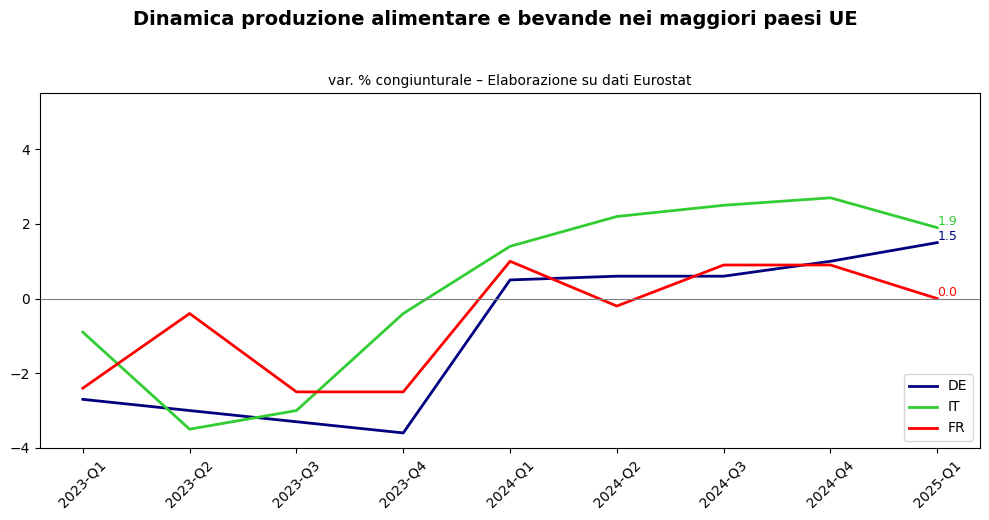

In [41]:
fig, ax = plt.subplots(figsize=(10, 5))
colori = {"DE": "navy", "IT": "limegreen", "FR": "red"}
for paese in ["DE", "IT", "FR"]:
    ax.plot(df_pivot.index, df_pivot[paese], label=paese, linewidth=2, color=colori[paese])
    ultimo_periodo = df_pivot[paese].last_valid_index()
    ultimo_valore = df_pivot.loc[ultimo_periodo, paese]
    ax.text(ultimo_periodo, ultimo_valore, f"{ultimo_valore:.1f}", color=colori[paese], fontsize=9, va='bottom')

fig.suptitle("Dinamica produzione alimentare e bevande nei maggiori paesi UE", fontsize=14, fontweight="bold", y=1.03)
ax.set_title("var. % congiunturale – Elaborazione su dati Eurostat", fontsize=10)

ax.set_ylim(-4, 5.5)
ax.axhline(0, color="gray", linewidth=0.8)
ax.set_xticks(range(len(df_pivot.index)))
ax.set_xticklabels(df_pivot.index, rotation=45)
ax.legend(title="", loc="lower right")
plt.tight_layout()
plt.show()



## backup

### i NACE

In [15]:
nace_list = df_clean['nace_r2'].unique().tolist()

# Imposta ogni quanti elementi andare a capo
per_riga = 16

for i in range(0, len(nace_list), per_riga):
    blocco = nace_list[i:i+per_riga]
    print("  ".join(blocco))



B  B-D  B-D_X_FOOD  B05  B051  B052  B06  B061  B062  B07  B071  B072  B08  B081  B089  B0891
B0892  B0893  B0899  B09  B_C  B_C_X_FD_MIG_NRG  B_C_X_MIG_NRG  C  C10  C10-C12  C101  C1011  C1012  C1013  C102  C103
C1031  C1032  C1039  C104  C1041  C1042  C105  C1051  C1052  C106  C1061  C1062  C107  C1071  C1072  C1073
C108  C1081  C1082  C1083  C1084  C1085  C1086  C1089  C109  C1091  C1092  C10_C11  C11  C1101  C1102  C1103
C1104  C1105  C1106  C1107  C12  C13  C13-C15  C131  C132  C133  C139  C1391  C1392  C1393  C1394  C1395
C1396  C1399  C13_C14  C14  C141  C1411  C1412  C1413  C1414  C1419  C142  C143  C1431  C1439  C15  C151
C1511  C1512  C152  C16  C16-C18  C161  C162  C1621  C1622  C1623  C1624  C1629  C17  C171  C1711  C1712
C172  C1721  C1722  C1723  C1724  C1729  C17_C18  C18  C181  C1811  C1812  C1813  C1814  C182  C19  C191
C192  C20  C201  C2011  C2012  C2013  C2014  C2015  C2016  C2017  C202  C203  C204  C2041  C2042  C205
C2051  C2052  C2053  C2059  C206  C20_C21  C21  

In [16]:
nace_aggregati_it = {
    "B-D": "Estrazione, manifattura, fornitura energia",
    "B-D_X_FOOD": "Estrazione-manifattura-energia (escluso alimentare)",
    "B_C": "Estrazione e manifattura",
    "B_C_X_FD_MIG_NRG": "Estrazione e manifattura (esclusi alimentari, MIG ed energia)",
    "B_C_X_MIG_NRG": "Estrazione e manifattura (escluso energia e beni industriali)",
    "C10-C12": "Industria alimentare, bevande, tabacco",
    "C10_C11": "Alimentari e bevande",
    "C13_C14": "Tessile e abbigliamento",
    "C16-C18": "Legno, carta, stampa",
    "C17_C18": "Carta e stampa",
    "C20_C21": "Chimica e farmaceutica",
    "C31_C32": "Mobili e altre manifatture",
    "C26_C27": "Elettronica ed elettrotecnica",
    "_HTC": "Manifattura ad alta tecnologia",
    "C_HTC_M": "Manifattura ad alta tecnologia (modificata)",
    "C_LTC": "Manifattura a bassa tecnologia",
    "C_LTC_M": "Manifattura a bassa tecnologia (modificata)",
    "F_CC1": "Costruzioni civili - cluster 1",
    "F_CC2": "Costruzioni civili - cluster 2",
    "MIG_CAG": "Beni di consumo durevoli e semidurevoli",
    "MIG_COG": "Beni di consumo",
    "MIG_COG_X_FOOD": "Beni di consumo (esclusi alimentari)",
    "MIG_DCOG": "Beni di consumo durevoli",
    "MIG_ING": "Beni intermedi",
    "MIG_ING_CAG": "Beni intermedi e beni strumentali",
    "MIG_NDCOG": "Beni di consumo non durevoli",
    "MIG_NRG_X_D_E": "Energia (esclusi settori D ed E)",
    "MIG_NRG_X_E": "Energia (escluso settore E)"
}
df_clean["settore_it"] = df_clean["nace_r2"].map(nace_aggregati_it)

### i geo

['AT', 'BA', 'BE', 'BG', 'CY', 'CZ', 'DE', 'DK', 'EA19', 'EE', 'EL', 'ES', 'EU28', 'FI', 'FR', 'HR', 'HU', 'IE', 'IT', 'LT', 'LU', 'LV', 'ME', 'MK', 'MT', 'NL', 'NO', 'PL', 'PT', 'RO', 'RS', 'SE', 'SI', 'SK', 'TR', 'UK', 'CH', 'EA20', 'EU27_2020']

In [19]:
geo_labels_it = {
    "EA19": "Area Euro (19)",
    "EA20": "Area Euro (20)",
    "EU28": "UE a 28",
    "EU27_2020": "UE a 27",
    "AT": "Austria",
    "BE": "Belgio",
    "BG": "Bulgaria",
    "CY": "Cipro",
    "CZ": "Cechia",
    "DE": "Germania",
    "DK": "Danimarca",
    "EE": "Estonia",
    "EL": "Grecia",
    "ES": "Spagna",
    "FI": "Finlandia",
    "FR": "Francia",
    "HR": "Croazia",
    "HU": "Ungheria",
    "IE": "Irlanda",
    "IT": "Italia",
    "LT": "Lituania",
    "LU": "Lussemburgo",
    "LV": "Lettonia",
    "MT": "Malta",
    "NL": "Paesi Bassi",
    "PL": "Polonia",
    "PT": "Portogallo",
    "RO": "Romania",
    "SE": "Svezia",
    "SI": "Slovenia",
    "SK": "Slovacchia",
    "BA": "Bosnia-Erzegovina",
    "ME": "Montenegro",
    "MK": "Macedonia del Nord",
    "RS": "Serbia",
    "TR": "Turchia",
    "UK": "Regno Unito",
    "NO": "Norvegia",
    "CH": "Svizzera"
}


In [18]:
df_clean['s_adj'].unique().to_markdown()

AttributeError: 'numpy.ndarray' object has no attribute 'to_markdown'

## La colonna `unit` 
nel dataset Eurostat (`sts_inpr_q`) indica **l'unità di misura** o la **forma della variabile osservata**. Ecco cosa significano i valori che hai trovato:


### 🧾 Significato dei codici `unit`

| Codice       | Significato completo                                               | Interpretazione pratica                                                     |
| ------------ | ------------------------------------------------------------------ | --------------------------------------------------------------------------- |
| **I10**      | **Index (2015 = 100)**                                             | Indice grezzo o corretto, base 2015 = 100                                   |
| **I15**      | **Index (previous year = 100)**                                    | Indice base anno precedente = 100                                           |
| **I21**      | **Index (2021 = 100)**                                             | Indice con base anno 2021 = 100                                             |
| **PCH\_SM**  | **Percentage change compared to previous month/quarter**           | Variazione percentuale **congiunturale** (rispetto al trimestre precedente) |
| **PCH\_PRE** | **Percentage change compared to the same period of previous year** | Variazione percentuale **tendenziale** (anno su anno, stesso trimestre)     |


### 📌 Uso tipico:

* **Analisi congiunturale (PCH\_SM)**: utile per vedere la variazione a breve termine.
* **Analisi tendenziale (PCH\_PRE)**: usata nei report Eurostat, ISTAT, Bankitalia per evidenziare cicli.
* **Index (I10, I15, I21)**: utile per confronti lunghi nel tempo o tra paesi/settori.

In [ ]:
df_clean['unit'].unique().tolist()

In [ ]:
val_francia = df_clean[
    (df_clean["nace_r2"] == "C10_C11") &
    (df_clean["geo"] == "FR") &
    (df_clean["unit"] == "PCH_PRE") &
    (df_clean["s_adj"].isin(["CA", "SCA"]))
]["2024-Q2"].dropna()

print("🇫🇷 Francia C10_C11 – 2024-Q2:", val_francia.values)

In [ ]:
# Filtra i settori C10 e C11 (alimentari e bevande)
df_filtered = df_long[df_long["nace_r2"].isin(["C10", "C11"])]

# Filtra per i principali paesi UE
paesi_ue = ["IT", "DE", "FR", "ES", "NL"]
df_filtered = df_filtered[df_filtered["geo"].isin(paesi_ue)]

il DataFrame in formato long contiene:
- Produzione alimentare (C10) e bevande (C11),
- Indicatori diversi, tra cui: 
    - CA → dati corretti per giorni lavorativi (livelli)
    - SCA, PCH_PRE → variazioni percentuali tendenziali



In [ ]:
df_filtered

estrarre la variazione tendenziale (%) della produzione di alimenti e bevande per i principali paesi UE
Per farlo, selezioniamo:
- indic_bt = PRD (produzione),
- unit = PCH_PRE (variazione %),
- s_adj = CA o SCA (dipende da cosa Eurostat ha caricato),
- nace_r2 = C10 (alimenti) + C11 (bevande),
- geo ∈ [IT, DE, FR, ES, NL],
- periodo ∈ ["2023-Q1", ..., "2025-Q1"]

In [ ]:
# Filtra solo variazioni percentuali tendenziali (% rispetto allo stesso trimestre anno precedente)
df_var_tendenziale = df_filtered[
    (df_filtered["unit"] == "PCH_PRE") &
    (df_filtered["indic_bt"] == "PRD") &
    (df_filtered["s_adj"].isin(["CA", "SCA"])) &  # correzione per giorni lavorativi
    (df_filtered["periodo"].between("2023-Q1", "2025-Q1"))
]

# Rinomina chiavi per chiarezza
df_var_tendenziale = df_var_tendenziale.assign(
    settore = df_var_tendenziale["nace_r2"].map({"C10": "Alimenti", "C11": "Bevande"})
)



# Pivot per avere: righe = periodo, colonne = (paese, settore)
df_pivot = df_var_tendenziale.pivot_table(
    index="periodo",
    columns=["geo", "settore"],
    values="valore"
).sort_index()
df_pivot
